In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from keras.applications import resnet
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, ZeroPadding2D, BatchNormalization, Layer
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
import os
import pandas as pd
from data_explorer import get_celebrities, show_gb, gbdf_to_list, get_tvt, refactor_identity

In [3]:
epochs = 50
batch_size = 16
margin = 1  # Margin for constrastive loss.

In [4]:
img_dir = "main_img/"
img_size = (178,218)
num_classes = 80

In [5]:
def preprocess_image(img_name):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """
    filename = img_dir + img_name
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, img_size)
    return image

def preprocess_pairs(pair):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return [preprocess_image(pair[0]), preprocess_image(pair[1])]

In [6]:
identity_df, rest = get_celebrities(num_classes, refactor_class=True)
identity_df.drop(["Identity"], axis=1, inplace=True)

In [7]:
identity_df["image"] = identity_df.apply(lambda row: preprocess_image(row["Image_name"]), axis=1)

In [8]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """
    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

    return np.array(pairs), np.array(labels).astype("float32")

In [9]:
train_df = identity_df[identity_df["class"]<40]
val_df = refactor_identity(identity_df[(identity_df["class"]>=40) & (identity_df["class"]<60)], "class")
test_df = refactor_identity(identity_df[identity_df["class"]>=60], "class")

c:\Users\magal\OneDrive\Documentos\TFG_mateu\TFG\data_explorer.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["class"] = df.apply(lambda row: d[row[traget_col]], axis=1)
c:\Users\magal\OneDrive\Documentos\TFG_mateu\TFG\data_explorer.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["class"] = df.apply(lambda row: d[row[traget_col]], axis=1)


In [10]:
x_train, y_train =   train_df["image"].to_numpy(), train_df["class"].to_numpy()

x_val, y_val =  val_df["image"].to_numpy(), val_df["class"].to_numpy()

x_test, y_test =  test_df["image"].to_numpy(), test_df["class"].to_numpy()

In [11]:
# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

# make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)

In [12]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]

In [13]:
x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_val_2 = pairs_val[:, 1]

In [14]:
x_test_1 = pairs_test[:, 0]  # x_test_1.shape = (20000, 28, 28)
x_test_2 = pairs_test[:, 1]

In [15]:

def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(7, 7))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1))
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], float(predictions[i][0])))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()


Inspect training pairs

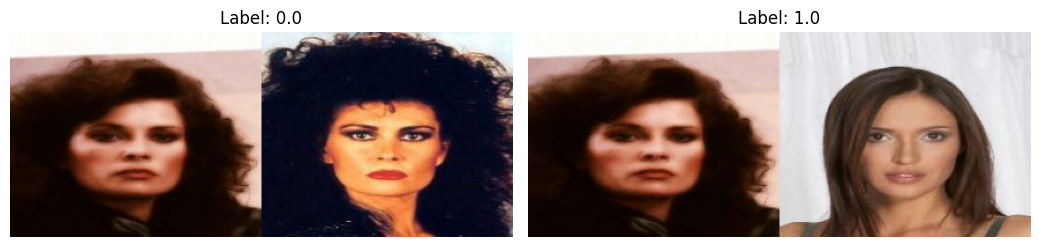

In [16]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=2, num_col=2)

Inspect validation pairs

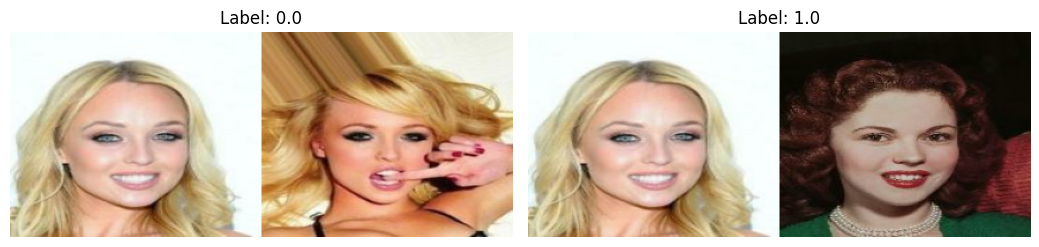

In [17]:
visualize(pairs_val[:-1], labels_val[:-1], to_show=2, num_col=2)

Inspect test pairs

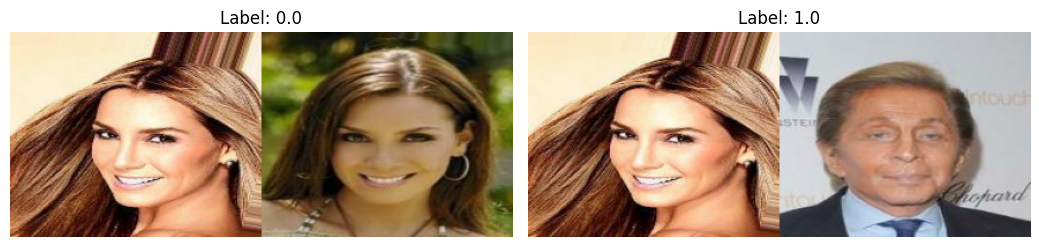

In [18]:
visualize(pairs_test[:-1], labels_test[:-1], to_show=2, num_col=2)

## Define the model

There are two input layers, each leading to its own network, which
produces embeddings. A `Lambda` layer then merges them using an
[Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) and the
merged output is fed to the final network.

In [19]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [20]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=img_size + (3,), include_top=False
)
input = base_cnn.input
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(64, (5, 5), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(128, (5, 5), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(256, (5, 5), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(256*2, (5, 5), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
output = layers.Dense(200, activation="relu")(x)

embedding_network = keras.Model(input, output)

In [21]:
trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [22]:
input_1 = layers.Input((178, 218, 3))
input_2 = layers.Input((178, 218, 3))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)



## Define the constrastive Loss

In [23]:

def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


## Compile the model with the contrastive loss

In [24]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 178, 218, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 178, 218, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 200)          5958228     ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [25]:
# https://github.com/hlamba28/Offline-Signature-Verification-using-Siamese-Network/blob/master/SigNet-BHSig260.ipynb
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=15, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('./Weights/weights_epoch_{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

## Train the model

In [26]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks = callbacks
)

Epoch 1/50
155/155 [==============================] - ETA: 0s - loss: 0.3292 - accuracy: 0.4717
Epoch 1: saving model to ./Weights\weights_epoch_001.h5
155/155 [==============================] - 451s 3s/step - loss: 0.3292 - accuracy: 0.4717 - val_loss: 0.3314 - val_accuracy: 0.4575 - lr: 0.0010
Epoch 2/50
155/155 [==============================] - ETA: 0s - loss: 0.2960 - accuracy: 0.4802
Epoch 2: saving model to ./Weights\weights_epoch_002.h5
155/155 [==============================] - 436s 3s/step - loss: 0.2960 - accuracy: 0.4802 - val_loss: 0.2833 - val_accuracy: 0.4908 - lr: 0.0010
Epoch 3/50
155/155 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.4952
Epoch 3: saving model to ./Weights\weights_epoch_003.h5
155/155 [==============================] - 441s 3s/step - loss: 0.2741 - accuracy: 0.4952 - val_loss: 0.2696 - val_accuracy: 0.4792 - lr: 0.0010
Epoch 4/50
155/155 [==============================] - ETA: 0s - loss: 0.2663 - accuracy: 0.4939
Epoch 4: savi

## Visualize results

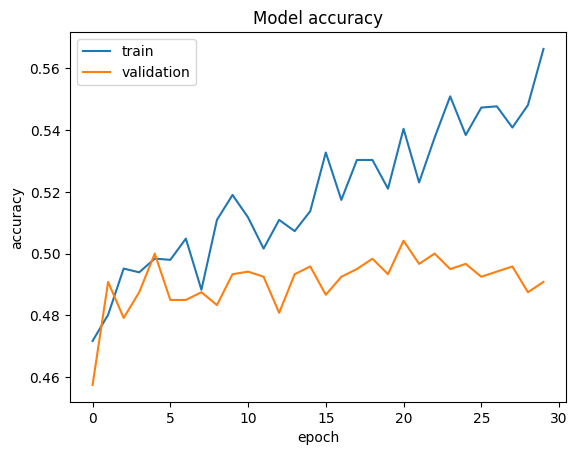

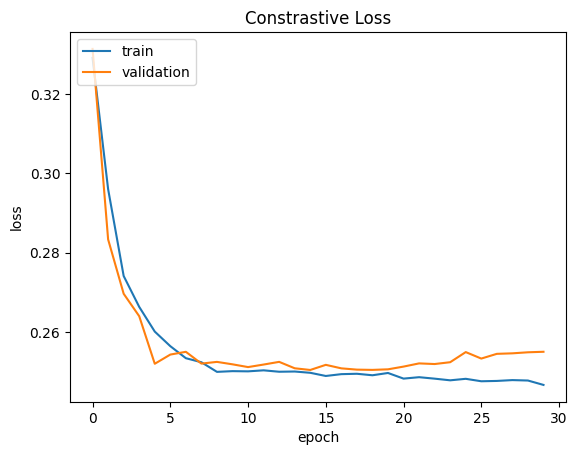

In [27]:

def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

## Evaluate the model

In [28]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

38/38 [==============================] - 35s 917ms/step - loss: 0.2553 - accuracy: 0.4867
test loss, test acc: [0.2552601993083954, 0.4866666793823242]


## Visualize the predictions

In [29]:
predictions = siamese.predict([x_test_1, x_test_2])


38/38 [==============================] - 35s 917ms/step


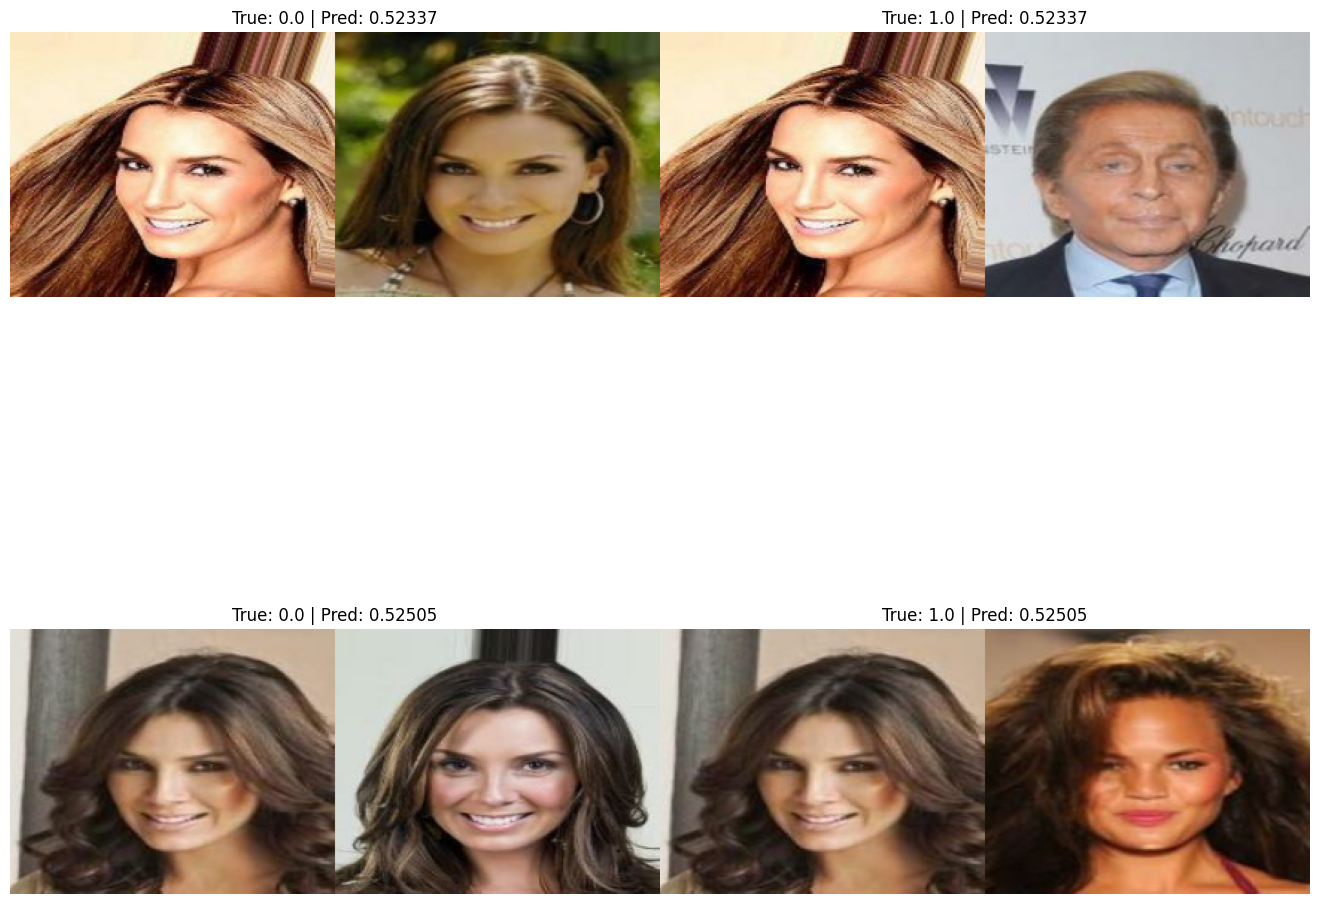

In [30]:
visualize(pairs_test, labels_test, to_show=4, num_col=2, predictions=predictions, test=True)